##  PVLIB tutorial output

In [ ]:
# needvariables :
# - temp_air
# - relative_humidity
# - IR(h)
# - wind_speed
# - wind_direction
# - pressure
#surface_tilt(latitude)


# system
# inverter
#module
#surface_azimuth

In [46]:
import pvlib
from pvlib import location
import pandas as pd
import matplotlib.pyplot as plt

# latitude, longitude, name, altitude, timezone
coordinates = [
    (32.2, -111.0, 'Tucson', 700, 'Etc/GMT+7'),
    (35.1, -106.6, 'Albuquerque', 1500, 'Etc/GMT+7'),
    (37.8, -122.4, 'San Francisco', 10, 'Etc/GMT+8'),
    (52.5, 13.4, 'Berlin', 34, 'Etc/GMT-1'),
]

 # get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Silevo_Triex_U300_Black__2014_']
inverter = sapm_inverters['SMA_America__SB3800TL_US_22__240V_']
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [56]:
tmys = []
for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)
weather


,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
utc_time,,,,,,,,,
2021-01-01 00:00:00+00:00,5.10,90.47,0.0,0.0,0.0,315.09,3.10,163.0,99547.0
2021-01-01 01:00:00+00:00,4.06,90.92,0.0,0.0,0.0,307.62,2.82,164.0,99527.0
2021-01-01 02:00:00+00:00,3.02,91.38,0.0,0.0,0.0,300.15,2.54,166.0,99547.0
2021-01-01 03:00:00+00:00,1.98,91.83,0.0,0.0,0.0,292.68,2.25,171.0,99547.0
2021-01-01 04:00:00+00:00,0.94,92.28,0.0,0.0,0.0,285.21,1.97,174.0,99566.0
...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00+00:00,10.30,88.21,0.0,0.0,0.0,352.44,4.52,261.0,100393.0
2021-12-31 20:00:00+00:00,9.26,88.67,0.0,0.0,0.0,344.97,4.24,274.0,100472.0
2021-12-31 21:00:00+00:00,8.22,89.12,0.0,0.0,0.0,337.50,3.96,274.0,100542.0


In [ ]:
# need:
# - temp_air
# - relative_humidity
# - IR(h)
# - wind_speed
# - wind_direction
# - pressure
#surface_tilt(latitude)


# system
# inverter
#module
#surface_azimuth

100917.2248728345

                           apparent_zenith      zenith  apparent_elevation  \
utc_time                                                                     
2018-01-01 00:00:00+00:00        85.187573   85.341399            4.812427   
2018-01-01 01:00:00+00:00        96.642131   96.642131           -6.642131   
2018-01-01 02:00:00+00:00       108.594875  108.594875          -18.594875   
2018-01-01 03:00:00+00:00       120.968144  120.968144          -30.968144   
2018-01-01 04:00:00+00:00       133.582571  133.582571          -43.582571   
...                                    ...         ...                 ...   
2015-12-31 19:00:00+00:00        55.628954   55.651534           34.371046   
2015-12-31 20:00:00+00:00        55.811080   55.833757           34.188920   
2015-12-31 21:00:00+00:00        59.543375   59.569467           30.456625   
2015-12-31 22:00:00+00:00        66.220264   66.254835           23.779736   
2015-12-31 23:00:00+00:00        75.040312   75.096252          

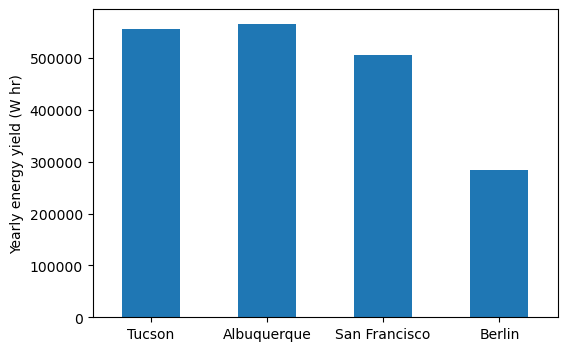

In [53]:
system = {'module': module, 'inverter': inverter,
          'surface_azimuth': 180}

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    system['surface_tilt'] = latitude
    solpos = pvlib.solarposition.get_solarposition(
        time=weather.index,
        latitude=latitude,
        longitude=longitude,
        altitude=altitude,
        temperature=weather["temp_air"],
        pressure=pvlib.atmosphere.alt2pres(altitude),
    )
    print(solpos)
    dni_extra = pvlib.irradiance.get_extra_radiation(weather.index)
    airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
    pressure = pvlib.atmosphere.alt2pres(altitude)
    am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
    aoi = pvlib.irradiance.aoi(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos["apparent_zenith"],
        solpos["azimuth"],
    )


    
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        system['surface_tilt'],
        system['surface_azimuth'],
        solpos['apparent_zenith'],
        solpos['azimuth'],
        weather['dni'],
        weather['ghi'],
        weather['dhi'],
        dni_extra=dni_extra,
        model='haydavies',
    )

    cell_temperature = pvlib.temperature.sapm_cell(
        total_irradiance['poa_global'],
        weather["temp_air"],
        weather["wind_speed"],
        **temperature_model_parameters,
    )
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
        total_irradiance['poa_direct'],
        total_irradiance['poa_diffuse'],
        am_abs,
        aoi,
        module,
    )
    dc = pvlib.pvsystem.sapm(effective_irradiance, cell_temperature, module)
    ac = pvlib.inverter.sandia(dc['v_mp'], dc['p_mp'], inverter)
    annual_energy = ac.sum()
    energies[name] = annual_energy

energies = pd.Series(energies)

# based on the parameters specified above, these are in W*hrs
print(energies)

energies.plot(kind='bar', rot=0)
plt.ylabel('Yearly energy yield (W hr)')
plt.gcf().set_size_inches(6, 4)  # Set the figure size (width, height)
plt.savefig('proc-energies.png')
plt.show()
plt.close()

In [44]:
data = {
    "Tucson": [445963.743286, 385394.979180],
    "Albuquerque": [456913.870381, 396555.402503],
    "San Francisco": [418051.696108, 357944.652985],
    "Berlin": [251239.339081, 195567.795027]
}

# Create DataFrame
df = pd.DataFrame(data)

percent = df.pct_change() * 100









